In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle as pkl
from ani1x_dataset import ANI1xDataset

In [11]:
def read_train_losses(directory):
    energy_list = []
    force_list = []
        
    for j in range(1,1001):
        try:
            energy_file = f'energy_losses_{j}000.npy'
            energy_path = os.path.join(directory, energy_file)
            energy_loss = np.sqrt(np.mean(np.load(energy_path)**2))
            energy_list.append(energy_loss)

            force_file = f'force_losses_{j}000.npy'
            force_path = os.path.join(directory, force_file)
            force_loss = np.sqrt(np.mean(np.load(force_path)**2))
            force_list.append(force_loss)
        except:
            pass
    
    x_array = np.arange(1, 1001)*1000
    energy_array = np.array(energy_list)
    force_array = np.array(force_list)
        
    return x_array, energy_array, force_array

def read_val_losses(directory):
    with open(f'{directory}/validation.pkl','rb') as f:
        data = pkl.load(f)
    x_array = np.array(list(data['energy'].keys())[:100])
    energy_array = np.array(list(data['energy'].values())[:100])
    force_array = np.array(list(data['force'].values())[:100])
    
    return x_array, energy_array, force_array

def read_test_losses(directory, dataset=test_dataset, idx=1000000):
    with open(f'{directory}/test_{idx}.pkl','rb') as f:
        test_data = pkl.load(f)
    energy_error = 627.5 * np.sqrt(np.mean([(pred-true)**2 for pred, true in zip(test_data['energy_pred'], test_dataset.energy_list)]))
    force_error = 627.5 * np.sqrt(np.mean([np.mean((pred-true)**2) for pred, true in zip(test_data['force_pred'], test_dataset.force_list)]))
    return energy_error, force_error

def plot_average(x_array, y_array, num_pts=10):
    new_x_list = []
    new_y_list = []
    
    N = len(x_array)
    for start in range(0, N, num_pts):
        new_x_list.append(np.sqrt(np.mean(x_array[start:start+num_pts]**2)))
        new_y_list.append(np.sqrt(np.mean(y_array[start:start+num_pts]**2)))
    return new_x_list, new_y_list

def read_ensemble_data(model_dir, dataset, idx_list):
    dict_list = []
    for idx in idx_list:
        with open(f'{model_dir}/test_{idx}.pkl','rb') as f:
            data = pkl.load(f)
        dict_list.append(data)
    return dict_list

def ensemble_test_loss(dict_list, dataset, idx=1000000):
    force_pred = []
    energy_pred = []
    for i in range(len(test_dataset)):
        force_pred.append(np.mean([model_dict['force_pred'][i] for model_dict in dict_list], axis=0))
        energy_pred.append(np.mean([model_dict['energy_pred'][i] for model_dict in dict_list], axis=0))
    energy_error = 627.5 * np.sqrt(np.mean([(pred-true)**2 for pred, true in zip(energy_pred, test_dataset.energy_list)], axis=0))
    force_error = 627.5 * np.sqrt(np.mean([np.mean((pred-true)**2) for pred, true in zip(force_pred, test_dataset.force_list)], axis=0))
    return energy_error, force_error

In [25]:
# Load data

test_dataset = ANI1xDataset(mode='test')

with open('plot_data.pkl', 'rb') as f:
    plot_data = pkl.load(f)

Loading dataset


In [19]:
# Performance of ensembled models
last_ten = np.arange(991000, 1000001, 1000)
model_name_list = ['basic', 'mean', 'deeper', 'wider', 'higher', 'heads']
print('Test errors:\tEnergy\tForce')
for model_name in model_name_list:
    model_dir = f'./models/{model_name}'
    dict_list = read_ensemble_data(model_dir, test_dataset, last_ten)
    losses = ensemble_test_loss(dict_list)
    print(f'{os.path.basename(model_dir)}:\t\t{losses[0]:.3f}\t{losses[1]:.3f}')

Test errors:	Energy	Force
basic:		2.908	4.262
mean:		3.630	4.669
deeper:		2.381	3.316
wider:		3.259	4.195
higher:		2.621	3.832
heads:		2.855	3.957


In [23]:
# Performance of ensemble of top three models
top_three_model_names = ['deeper', 'higher', 'heads']
top_three_list = []
print('Test errors:\tEnergy\tForce')
for model_name in top_three_model_names:
    model_dir = f'./models/{model_name}'
    dict_list = read_ensemble_data(model_dir, test_dataset, last_ten)
    top_three_list += dict_list
losses = ensemble_test_loss(top_three_list)
print(f'top three:\t{losses[0]:.3f}\t{losses[1]:.3f}')

Test errors:	Energy	Force
top three:	2.209	3.177


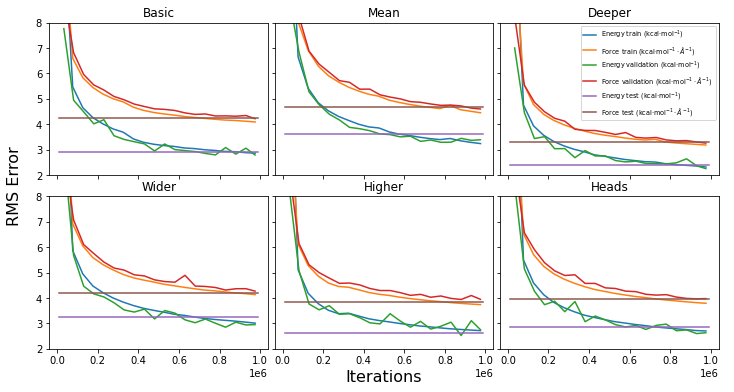

In [26]:
train_ave_num = 50 # Number of saves to average over
val_ave_num = 5 # Number of saves to average over

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,6))

model_name_list = ['basic', 'mean', 'deeper', 'wider', 'higher', 'heads']
for i in range(6):
    model_name = model_name_list[i]
    model_dict = plot_data[model_name]
    model_dir = f'./models/{model_name}'
    
    ax = axes[i//3, i%3]
    
    # Plot training
    x_train = model_dict['train']['x']
    energy_train = model_dict['train']['energy']
    force_train = model_dict['train']['force']
    ax.plot(*plot_average(x_train, energy_train, num_pts=train_ave_num), label='Energy train')
    ax.plot(*plot_average(x_train, force_train, num_pts=train_ave_num), label='Force train')
    
    # Plot validation
    x_val = model_dict['val']['x']
    energy_val = model_dict['val']['energy']
    force_val = model_dict['val']['force']
    ax.plot(*plot_average(x_val, energy_val, num_pts=val_ave_num), label='Energy validation')
    ax.plot(*plot_average(x_val, force_val, num_pts=val_ave_num), label='Force validation')
    
    # Plot test (reuse x_val instead of making an x_test)
    energy_test = model_dict['test']['energy'] * np.ones(len(x_val))
    force_test = model_dict['test']['force'] * np.ones(len(x_val))
    ax.plot(x_val, energy_test, label='Energy validation')
    ax.plot(x_val, force_test, label='Force validation')
    
    # ax formatting
    ax.set_ylim(2,8)
    ax.set_title(model_name.capitalize(), fontsize=12)
    
plt.subplots_adjust(wspace=0.03, hspace=0.14)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.xlabel('Iterations', fontsize=16)
plt.ylabel(r'RMS Error', fontsize=16)
fig.legend(['Energy train (kcal$\cdot$mol$^{-1})$',
            'Force train (kcal$\cdot$mol$^{-1}\cdot\AA^{-1})$', 
            'Energy validation (kcal$\cdot$mol$^{-1})$', 
            'Force validation (kcal$\cdot$mol$^{-1}\cdot\AA^{-1})$',
            'Energy test (kcal$\cdot$mol$^{-1}$)',
            'Force test (kcal$\cdot$mol$^{-1}\cdot\AA^{-1})$'],
           bbox_to_anchor=(0.9, 0.88), loc='upper right', fontsize=6.5)
plt.savefig('losses.png')
plt.show()